# Exercício 2
## 3ª Lista de Fundamentos em Redes Neurais e Aprendizagem Estatística
### by Lorran de Araújo Durães Soares

# Imports:

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

np.random.seed(42) # setando semente

2024-08-28 11:11:51.918076: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 11:11:52.126052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 11:11:52.285148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 11:11:52.387553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 11:11:52.627191: I tensorflow/core/platform/cpu_feature_guar

# Pré processamento:

Baixando conjunto de imagens do cifar10:

In [3]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas as categorias aviões e carros:

In [4]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Reduzindo a quantidade de dados:

In [5]:
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(x_filt, y_filt, test_size=1-sample_size, random_state=42)
print(x_filt.shape)
print(X_sample.shape)

(12000, 32, 32, 3)
(1200, 32, 32, 3)


Plotando imagens exemplos da base de dados:

In [6]:
def plot_images_grid(images, titles, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # achata o array de eixos para facilitar o acesso

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

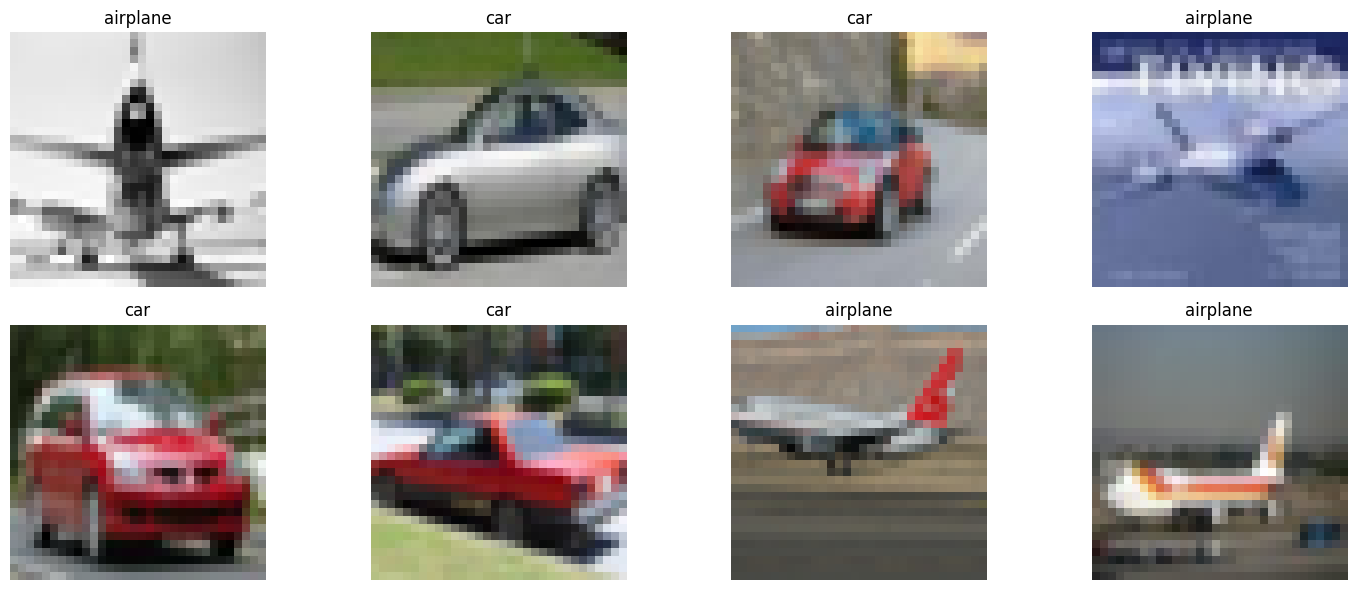

In [7]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 12
list_imgs = []
example_label = []

for i in range(8):
    list_imgs.append(X_sample[num_imagem*i])
    example_label.append(category_labels[y_sample[num_imagem*i][0]])

plot_images_grid(images=list_imgs, titles=example_label)

Dividindo dados em conjunto de treino e testes:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42, shuffle=True)

Plota histograma de frequência para verificação de desbalanceamento de dados:

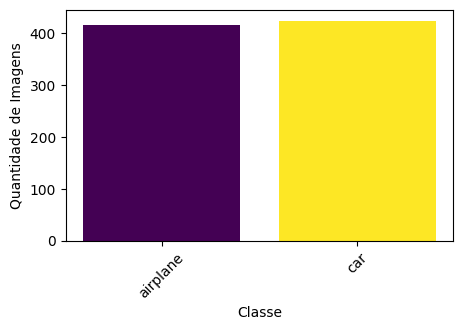

In [9]:
# Conta a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotar o histograma
class_names = ['airplane', 'car']

colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))

plt.figure(figsize=(5, 3))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names, color=colors)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()

# Modelo

Criando modelo:

In [10]:
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # Correção na forma de definir os parâmetros do otimizador
    optimizer = Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999, epsilon=1e-8, amsgrad=True)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

    return model

Treinando com 5 k-folds

In [12]:
# define o número de folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# lista para armazenar os históricos e as pontuações de cada fold
histories = []

# lista para armazenar cada modelo
models = []

# executa a validação cruzada
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    x_train2, x_val = X_train[train_index], X_train[val_index]
    y_train2, y_val = y_train[train_index], y_train[val_index]
    
    # cria e treina o modelo
    model = create_model()
    history = model.fit(x_train2, y_train2, epochs=20, batch_size=32,
                        validation_data=(x_val, y_val), verbose=1)
    
    models.append(model)
    
    # armazenar o historico do fold
    histories.append(history.history)
    
    # avalia e exibe a pontuação
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Fold {fold + 1} - Acurácia: {score[1]:.4f}')

/home/lorran/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6563 - loss: 2.9206 - val_accuracy: 0.8542 - val_loss: 0.3446
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.8680 - loss: 0.3173 - val_accuracy: 0.8899 - val_loss: 0.2834
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9037 - loss: 0.2344 - val_accuracy: 0.8964 - val_loss: 0.2587
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9246 - loss: 0.1857 - val_accuracy: 0.9161 - val_loss: 0.2249
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9432 - loss: 0.1653 - val_accuracy: 0.9095 - val_loss: 0.2476
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.9497 - loss: 0.1358 - val_accuracy: 0.9208 - val_loss: 0.2251
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9511 - loss: 0.1209 - val_accuracy: 0.9262 - val_loss: 0.2130
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.9618 - loss: 0.0962

Plotando graficos de acurácia e perda para cada fold:

In [1]:
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    # plota acuracia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Treinamento')
    plt.plot(history['val_accuracy'], label='Validação')
    plt.title(f'Fold {fold + 1} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Fold {fold + 1} - Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

NameError: name 'histories' is not defined

Calculando matriz de confusão e métricas:

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


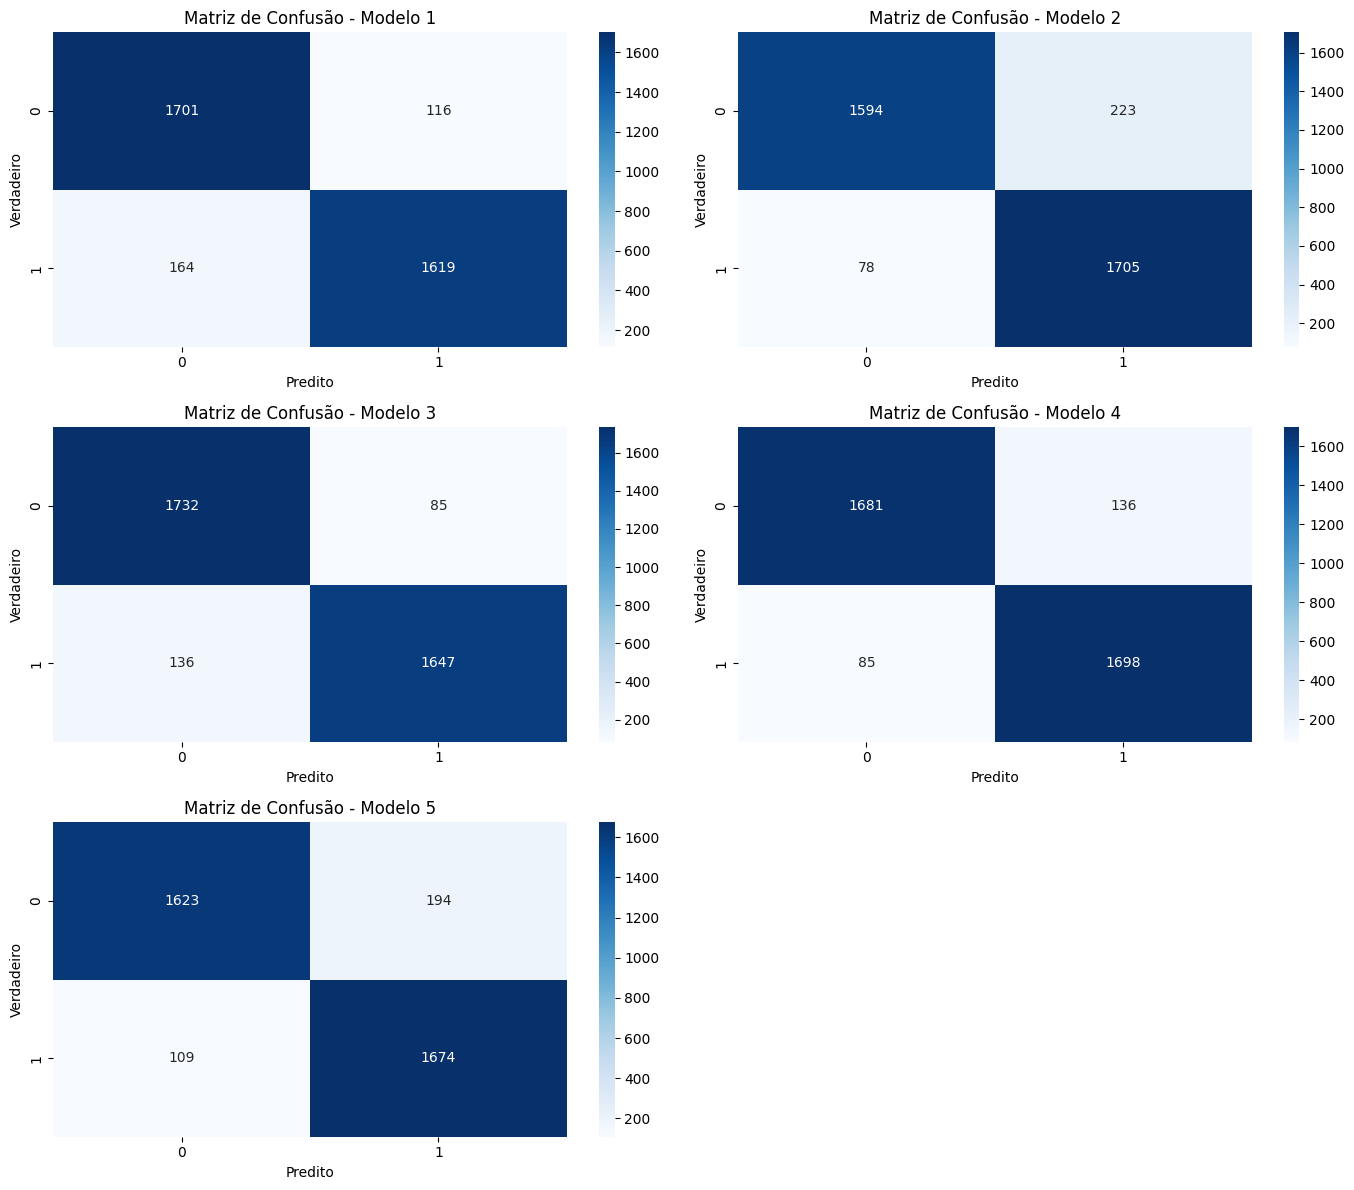

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Relatório de Classificação - Modelo 1:

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1817
           1       0.93      0.91      0.92      1783

    accuracy                           0.92      3600
   macro avg       0.92      0.92      0.92      3600
weighted avg       0.92      0.92      0.92      3600

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Relatório de Classificação - Modelo 2:

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      1817
           1       0.88      0.96      0.92      1783

    accuracy                           0.92      3600
   macro avg       0.92      0.92      0.92      3600
weighted avg       0.92      0.92      0.92      3600

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Relatório de Classificação - Modelo 3:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     

In [14]:
num_models = len(models)

# cria a figura principal com subplots organizados em uma grade de 2x2
plt.figure(figsize=(14, 12))

for i, md in enumerate(models):
    y_pred = md.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes

    # cria a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # subplot para cada matriz de confusão
    plt.subplot(3, 2, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - Modelo {i + 1}')


plt.tight_layout()
plt.show()

# calcula e imprime o relatório de classificação para cada modelo
for i, md in enumerate(models):
    y_pred = md.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes
    report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(2)])
    print(f'Relatório de Classificação - Modelo {i + 1}:\n')
    print(report)